In [1]:
# Import Packages
import pandas as pd
import numpy as np
import os
import sys
import dtale
# import holidays
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from catboost import CatBoostClassifier
# from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

%matplotlib inline


# Folder Structure
SCRIPT_DIR = (os.path.dirname(os.path.realpath("__file__")))
DATA_DIR = os.path.join(os.path.dirname(SCRIPT_DIR), "data")

# Read Data
train = pd.read_csv(f"{DATA_DIR}/train.csv")
test = pd.read_csv(f"{DATA_DIR}/test.csv")

print(train.shape, test.shape)
train.sample()

(20453, 800) (8774, 799)


,row_id,scout_id,rating_num,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
7362,10130,16,10.0,loser,team1,8,9.0,9.0,0.560976,0.46,...,0.193658,0.212006,0.353557,0.545857,0.318946,0.516103,0.098819,0.500782,0.361036,0.563543


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20453 entries, 0 to 20452
Columns: 800 entries, row_id to team2_offensive_derived_var_19
dtypes: float64(794), int64(4), object(2)
memory usage: 124.8+ MB


In [3]:
def encode_winner(df):

    print("*** BEFORE encode_team")
    print(f"Value Counts:\n{df['winner'].value_counts()}")
    print(f"Nulls:\n{df['winner'].isnull().sum()}")

    winner_mapping_obj = {
        'loser': -1,
        'draw': 0,
        'winner': 1
    }

    df['winner'] = df['winner'].map(winner_mapping_obj)

    print("*** AFTER encode_team")
    print(f"Value Counts:\n{df['winner'].value_counts()}")
    print(f"Nulls:\n{df['winner'].isnull().sum()}")

    return df


def encode_team(df):

    print("*** BEFORE encode_team")
    print(f"Value Counts:\n{df['team'].value_counts()}")
    print(f"Nulls:\n{df['team'].isnull().sum()}")

    team_mapping_obj = {
        'team1': 1,
        'team2': 2
    }

    df['team'] = df['team'].map(team_mapping_obj)

    print("*** AFTER encode_team")
    print(f"Value Counts:\n{df['team'].value_counts()}")
    print(f"Nulls:\n{df['team'].isnull().sum()}")

    return df


def impute_team(df):

    # Impute 1 missing value in team -- test data
    df['team'] = df['team'].fillna(df['team'].median())
    print(df['team'].isnull().sum())

    return df

idx_cols = ['row_id']
def transform_data(df):

    df = encode_winner(df)
    df = encode_team(df)
    df = impute_team(df)

    df = df.set_index(idx_cols)

    return df


train_catboost = transform_data(train)
train_catboost['rating_str'] = train_catboost['rating_num'].astype(str)
test_catboost = transform_data(test)
print(train_catboost.shape)
train_catboost.sample()

*** BEFORE encode_team
Value Counts:
winner    8735
loser     6442
draw      5276
Name: winner, dtype: int64
Nulls:
0
*** AFTER encode_team
Value Counts:
 1    8735
-1    6442
 0    5276
Name: winner, dtype: int64
Nulls:
0
*** BEFORE encode_team
Value Counts:
team1    10306
team2    10147
Name: team, dtype: int64
Nulls:
0
*** AFTER encode_team
Value Counts:
1    10306
2    10147
Name: team, dtype: int64
Nulls:
0
0
*** BEFORE encode_team
Value Counts:
winner    3258
loser     3236
draw      2280
Name: winner, dtype: int64
Nulls:
0
*** AFTER encode_team
Value Counts:
 1    3258
-1    3236
 0    2280
Name: winner, dtype: int64
Nulls:
0
*** BEFORE encode_team
Value Counts:
team1    4563
team2    4210
Name: team, dtype: int64
Nulls:
1
*** AFTER encode_team
Value Counts:
1.0    4563
2.0    4210
Name: team, dtype: int64
Nulls:
1
0
(20453, 800)


,scout_id,rating_num,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,...,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19,rating_str
row_id,,,,,,,,,,,,,,,,,,,,,
7116,13,7.0,-1,2,8,9.0,9.0,0.365854,0.46,0.0,...,0.174023,0.10393,0.858348,0.806841,0.681113,0.139555,0.440262,0.496348,0.102462,7.0


In [27]:
cat_features = [
    'scout_id', 'winner', 'team', 'competitionId',
    'team1_system_id', 'team2_system_id',
    'player_position_1', 'player_position_2'
]
num_features = [x for x in train.columns if x not in cat_features + idx_cols + ['rating_num']]
less_feature_imp = [
    'team1_offensive_derived_var_12', 'player_other_derived_var_20',
       'player_defensive_ratio_var_84', 'team1_other_raw_var_5',
       'team1_other_ratio_var_31', 'player_physical_raw_var_190',
       'team2_defensive_derived_var_1', 'team1_other_raw_var_44',
       'team1_other_ratio_var_19', 'team2_offensive_derived_var_12',
       'team2_other_raw_var_52', 'player_offensive_raw_var_122',
       'team1_offensive_derived_var_13', 'player_defensive_derived_var_7',
       'team1_other_ratio_var_7', 'team1_offensive_derived_var_7',
       'team2_defensive_derived_var_10',
       'player_offensive_derived_var_127', 'team1_other_ratio_var_50',
       'team2_defensive_derived_var_6', 'team2_other_raw_var_25',
       'team1_other_ratio_var_38', 'player_defensive_derived_var_11',
       'player_defensive_derived_var_122', 'team1_offensive_ratio_var_30',
       'team2_other_ratio_var_12', 'team2_other_raw_var_28',
       'team1_other_ratio_var_8', 'player_other_raw_var_184',
       'team2_defensive_derived_var_15', 'team2_other_ratio_var_51',
       'team1_offensive_raw_var_91', 'team2_other_ratio_var_27',
       'team1_other_ratio_var_13', 'player_positional_derived_var_100',
       'player_offensive_ratio_var_51', 'player_offensive_derived_var_91',
       'team2_other_raw_var_57', 'team2_other_raw_var_93',
       'team2_other_ratio_var_23', 'team1_other_ratio_var_34',
       'player_other_raw_var_68', 'team2_other_raw_var_44',
       'team2_other_ratio_var_8', 'player_offensive_derived_var_56',
       'team1_other_ratio_var_27', 'team1_other_raw_var_56',
       'team1_offensive_derived_var_0', 'player_physical_raw_var_191',
       'team2_other_ratio_var_44', 'team2_other_ratio_var_7',
       'player_defensive_raw_var_65', 'team1_defensive_raw_var_71',
       'team1_other_raw_var_52', 'player_defensive_derived_var_108',
       'team1_other_ratio_var_12', 'team1_other_raw_var_22',
       'player_offensive_derived_var_25', 'team1_other_ratio_var_21',
       'team1_other_raw_var_0', 'player_physical_derived_var_111',
       'player_defensive_derived_var_33', 'team1_offensive_ratio_var_9',
       'team2_other_raw_var_0', 'team1_defensive_derived_var_8',
       'player_physical_derived_var_131', 'team2_defensive_derived_var_8',
       'team1_other_raw_var_73', 'player_defensive_raw_var_95',
       'team2_other_ratio_var_49', 'player_positional_derived_var_92',
       'team1_other_ratio_var_36', 'team2_other_raw_var_55',
       'team1_offensive_derived_var_4', 'team2_offensive_derived_var_14',
       'team1_other_ratio_var_23', 'player_offensive_derived_var_128',
       'player_general_derived_var_156', 'player_other_raw_var_141',
       'team2_other_raw_var_65', 'player_physical_derived_var_36',
       'team1_offensive_derived_var_5', 'team1_other_raw_var_46',
       'team1_other_raw_var_76', 'team1_other_raw_var_28',
       'team2_other_raw_var_73', 'player_offensive_raw_var_105',
       'player_positional_raw_var_110', 'team2_other_ratio_var_26',
       'player_offensive_ratio_var_45', 'team1_other_raw_var_70',
       'player_other_derived_var_150', 'player_offensive_derived_var_3',
       'team2_other_raw_var_54', 'team2_other_ratio_var_14',
       'player_offensive_ratio_var_12', 'player_other_raw_var_63',
       'team1_other_ratio_var_3', 'team1_other_ratio_var_4',
       'team1_other_raw_var_20', 'team1_defensive_derived_var_6',
       'team1_other_raw_var_25', 'team2_other_raw_var_67',
       'team2_other_raw_var_59', 'player_positional_derived_var_27',
       'player_other_derived_var_123', 'team2_other_raw_var_63',
       'player_defensive_derived_var_134', 'player_other_raw_var_118',
       'player_physical_derived_var_40', 'team1_other_raw_var_54',
       'player_other_raw_var_119', 'player_physical_raw_var_196',
       'team2_other_raw_var_74', 'team1_other_raw_var_75',
       'team1_offensive_derived_var_11', 'team2_other_raw_var_46',
       'team1_other_raw_var_45', 'team2_other_raw_var_2',
       'team2_other_ratio_var_34', 'player_defensive_raw_var_74',
       'player_offensive_raw_var_116', 'team1_offensive_derived_var_16',
       'team2_offensive_derived_var_4', 'player_defensive_derived_var_98',
       'team2_other_ratio_var_31', 'player_other_raw_var_181',
       'team2_offensive_ratio_var_9', 'team2_other_ratio_var_4',
       'team1_other_ratio_var_43', 'player_offensive_ratio_var_57',
       'team2_other_raw_var_76', 'player_other_raw_var_58',
       'team1_offensive_raw_var_86', 'player_physical_derived_var_107',
       'team1_other_raw_var_89', 'player_defensive_raw_var_67',
       'team1_offensive_ratio_var_6', 'player_other_raw_var_75',
       'team1_other_ratio_var_17', 'player_other_raw_var_103',
       'player_other_raw_var_104', 'team1_other_ratio_var_44',
       'team1_other_ratio_var_28', 'player_defensive_derived_var_1',
       'team2_other_ratio_var_17', 'player_offensive_derived_var_120',
       'player_offensive_raw_var_126', 'player_offensive_derived_var_104',
       'team1_other_ratio_var_49', 'player_offensive_ratio_var_53',
       'player_other_ratio_var_80', 'team1_other_ratio_var_45',
       'player_other_ratio_var_15', 'team1_other_raw_var_58',
       'team2_offensive_raw_var_1', 'team1_other_raw_var_60',
       'player_offensive_raw_var_115', 'team1_other_raw_var_42',
       'team1_other_raw_var_88', 'team2_defensive_raw_var_29',
       'team1_defensive_derived_var_1', 'player_defensive_raw_var_93',
       'player_other_ratio_var_44', 'player_offensive_ratio_var_20',
       'team2_offensive_derived_var_5', 'team1_other_raw_var_87',
       'player_other_ratio_var_86', 'team2_other_ratio_var_11',
       'team2_other_ratio_var_42', 'team2_other_raw_var_69',
       'player_other_raw_var_44', 'player_other_derived_var_147',
       'player_defensive_derived_var_114', 'team2_offensive_raw_var_18',
       'team2_offensive_derived_var_0', 'player_other_ratio_var_75',
       'team1_other_ratio_var_29', 'team2_defensive_raw_var_17',
       'player_physical_raw_var_189', 'player_other_raw_var_124',
       'player_physical_raw_var_194', 'team1_offensive_raw_var_1',
       'player_offensive_ratio_var_50', 'team2_other_raw_var_23',
       'team1_offensive_ratio_var_24', 'player_defensive_derived_var_95',
       'player_other_ratio_var_49', 'team1_other_raw_var_26',
       'player_other_raw_var_107', 'player_offensive_ratio_var_21',
       'team2_offensive_raw_var_91', 'team1_offensive_ratio_var_48',
       'team1_other_raw_var_74', 'team1_other_raw_var_69',
       'player_physical_raw_var_195', 'team1_other_raw_var_65',
       'team2_other_ratio_var_28', 'player_defensive_derived_var_0',
       'team1_offensive_raw_var_18', 'team2_other_ratio_var_29',
       'player_defensive_derived_var_12', 'player_other_raw_var_56',
       'player_offensive_raw_var_130', 'player_defensive_derived_var_19',
       'team1_other_raw_var_78', 'player_other_ratio_var_31',
       'player_general_derived_var_152', 'player_other_raw_var_90',
       'player_other_raw_var_106', 'player_other_raw_var_8',
       'team2_other_ratio_var_50', 'team1_other_raw_var_83',
       'player_offensive_derived_var_60', 'team2_other_raw_var_48',
       'team2_defensive_raw_var_12', 'player_defensive_derived_var_102',
       'player_other_raw_var_123', 'player_defensive_derived_var_66',
       'player_offensive_derived_var_158', 'team2_other_raw_var_22',
       'player_physical_derived_var_39', 'team1_other_raw_var_59',
       'player_physical_derived_var_54', 'team2_other_ratio_var_39',
       'player_offensive_raw_var_102', 'team2_offensive_ratio_var_6',
       'player_other_raw_var_134', 'team1_other_raw_var_63',
       'player_offensive_raw_var_73', 'player_offensive_raw_var_87',
       'player_positional_derived_var_136', 'player_general_raw_var_143',
       'team2_other_raw_var_83', 'player_other_ratio_var_18',
       'player_defensive_derived_var_138', 'player_other_raw_var_34',
       'team2_other_raw_var_88', 'team2_other_raw_var_64',
       'team1_other_ratio_var_47', 'player_defensive_ratio_var_2',
       'player_positional_derived_var_14', 'team1_other_ratio_var_39',
       'player_defensive_raw_var_70', 'team2_other_raw_var_58',
       'team2_other_ratio_var_47', 'player_other_ratio_var_71',
       'player_other_derived_var_160', 'player_other_raw_var_81',
       'team1_defensive_derived_var_15', 'player_offensive_raw_var_120',
       'player_other_raw_var_84', 'player_physical_raw_var_198',
       'team1_other_raw_var_39', 'player_other_ratio_var_66',
       'player_physical_raw_var_192', 'player_offensive_raw_var_49',
       'team2_other_raw_var_70', 'team1_other_raw_var_64',
       'team2_offensive_derived_var_7', 'player_general_raw_var_78',
       'player_offensive_derived_var_63', 'player_other_raw_var_41',
       'team1_defensive_raw_var_29', 'team2_other_raw_var_45',
       'player_offensive_ratio_var_19', 'team2_other_raw_var_61',
       'player_other_raw_var_113', 'player_physical_derived_var_34',
       'player_other_derived_var_84', 'team2_other_ratio_var_22',
       'team2_other_raw_var_56', 'team2_defensive_raw_var_71',
       'player_positional_derived_var_44', 'team1_other_raw_var_8',
       'player_other_derived_var_141', 'team2_other_ratio_var_3',
       'player_offensive_derived_var_68',
       'player_physical_derived_var_10',
       'player_offensive_derived_var_81', 'team2_other_raw_var_75',
       'player_defensive_raw_var_94', 'player_other_raw_var_37',
       'team2_other_raw_var_8', 'team2_other_raw_var_90',
       'player_defensive_derived_var_58', 'player_defensive_raw_var_52',
       'player_offensive_raw_var_131', 'team2_other_raw_var_60',
       'player_other_raw_var_140', 'player_physical_derived_var_30',
       'team2_defensive_raw_var_9', 'team2_other_raw_var_26',
       'team2_other_raw_var_87', 'player_offensive_raw_var_133',
       'player_defensive_derived_var_65',
       'team1_offensive_derived_var_18', 'team2_other_raw_var_37',
       'team2_offensive_derived_var_11', 'player_other_derived_var_140',
       'player_other_raw_var_128', 'team1_other_raw_var_47',
       'player_physical_derived_var_45', 'player_defensive_raw_var_62',
       'player_defensive_raw_var_92', 'player_defensive_raw_var_4',
       'player_offensive_ratio_var_59', 'player_defensive_ratio_var_76',
       'team1_other_raw_var_2', 'team1_other_raw_var_27',
       'player_defensive_derived_var_101',
       'player_offensive_derived_var_73', 'team2_other_ratio_var_41',
       'team1_other_ratio_var_51', 'team1_other_raw_var_55',
       'player_offensive_derived_var_135', 'team2_other_raw_var_66',
       'player_physical_derived_var_112', 'player_physical_derived_var_4',
       'player_other_raw_var_47', 'team1_other_raw_var_67',
       'player_other_ratio_var_65', 'player_defensive_raw_var_165',
       'team2_other_raw_var_16', 'player_other_derived_var_157',
       'team1_other_raw_var_11', 'team1_other_raw_var_32',
       'player_physical_derived_var_62', 'player_other_raw_var_142',
       'player_physical_raw_var_193', 'team1_offensive_raw_var_13',
       'player_defensive_ratio_var_81', 'player_positional_raw_var_2',
       'player_other_raw_var_164', 'team2_other_raw_var_41',
       'team1_other_raw_var_37', 'team1_other_ratio_var_10',
       'team2_other_raw_var_89', 'player_offensive_derived_var_21',
       'player_other_ratio_var_34', 'player_other_ratio_var_7',
       'team1_other_ratio_var_42', 'team2_other_raw_var_47',
       'team1_system_id', 'player_defensive_derived_var_149',
       'team1_other_raw_var_90', 'team1_defensive_raw_var_17',
       'player_defensive_raw_var_137', 'team1_other_raw_var_80',
       'player_defensive_ratio_var_85', 'player_physical_derived_var_16',
       'player_offensive_derived_var_47', 'player_general_raw_var_71',
       'player_physical_derived_var_106', 'team1_other_raw_var_15',
       'player_offensive_derived_var_99', 'player_positional_raw_var_15',
       'player_positional_derived_var_22',
       'team1_offensive_derived_var_14', 'player_offensive_raw_var_50',
       'team2_other_raw_var_15', 'player_physical_derived_var_5',
       'player_defensive_ratio_var_16', 'player_other_raw_var_125',
       'player_positional_ratio_var_22', 'team2_other_raw_var_14',
       'team2_offensive_ratio_var_48', 'player_other_raw_var_169',
       'player_physical_derived_var_28', 'team2_other_raw_var_39',
       'player_offensive_derived_var_86',
       'player_positional_derived_var_15',
       'player_defensive_derived_var_67', 'player_other_raw_var_51',
       'player_other_derived_var_143', 'player_physical_derived_var_59',
       'player_other_raw_var_30', 'team1_offensive_raw_var_10',
       'player_defensive_derived_var_113',
       'player_physical_derived_var_74',
       'player_positional_derived_var_77', 'team2_defensive_raw_var_3',
       'player_general_raw_var_114', 'team2_defensive_raw_var_68',
       'player_offensive_ratio_var_40', 'player_other_derived_var_61',
       'player_physical_derived_var_18', 'player_physical_derived_var_70',
       'team1_other_raw_var_16', 'team2_offensive_raw_var_13',
       'player_positional_raw_var_21', 'team2_offensive_raw_var_86',
       'player_other_raw_var_12', 'player_other_raw_var_112',
       'player_other_raw_var_40', 'team2_other_raw_var_84',
       'team2_offensive_raw_var_7', 'player_general_derived_var_148',
       'player_offensive_ratio_var_69', 'team2_offensive_ratio_var_24',
       'player_other_raw_var_117', 'team2_other_raw_var_42',
       'player_defensive_ratio_var_3', 'player_physical_derived_var_121',
       'team2_other_raw_var_27', 'player_other_raw_var_88',
       'team2_offensive_raw_var_35', 'player_physical_derived_var_9',
       'player_positional_raw_var_17', 'player_other_raw_var_57',
       'player_defensive_derived_var_103',
       'player_physical_derived_var_69', 'team1_other_raw_var_84',
       'team2_other_ratio_var_52', 'player_other_raw_var_160',
       'player_other_raw_var_20', 'player_other_raw_var_83',
       'player_offensive_raw_var_182', 'player_offensive_raw_var_129',
       'player_offensive_ratio_var_13', 'team1_offensive_raw_var_7',
       'player_positional_raw_var_23', 'player_offensive_ratio_var_35',
       'team2_other_raw_var_34', 'player_other_raw_var_35',
       'player_offensive_raw_var_7', 'team2_other_ratio_var_10',
       'team1_other_raw_var_85', 'player_positional_derived_var_43',
       'player_physical_derived_var_118', 'player_other_ratio_var_33',
       'player_other_raw_var_27', 'player_other_raw_var_13',
       'team1_other_raw_var_34', 'player_other_raw_var_132',
       'team2_defensive_raw_var_6', 'player_other_ratio_var_5',
       'player_other_raw_var_80', 'player_offensive_raw_var_138',
       'player_other_raw_var_19', 'player_other_raw_var_175',
       'player_offensive_raw_var_53', 'player_positional_raw_var_0',
       'player_physical_derived_var_94', 'player_other_raw_var_39',
       'player_other_ratio_var_10', 'player_other_raw_var_101',
       'player_other_raw_var_147', 'player_other_raw_var_18',
       'player_general_var_0', 'team2_other_raw_var_85',
       'team1_other_ratio_var_52', 'team1_other_raw_var_30',
       'player_other_ratio_var_36', 'team1_other_raw_var_81',
       'team1_offensive_raw_var_35', 'team2_other_raw_var_30',
       'player_other_raw_var_188', 'player_other_raw_var_157',
       'player_offensive_raw_var_46', 'team2_other_raw_var_53',
       'player_defensive_derived_var_31', 'player_other_ratio_var_32',
       'player_defensive_raw_var_5', 'player_other_raw_var_172',
       'team2_other_raw_var_79', 'team2_other_raw_var_20',
       'player_defensive_derived_var_142', 'player_other_raw_var_85',
       'team2_other_raw_var_81', 'team2_offensive_raw_var_4',
       'player_offensive_raw_var_170', 'team2_other_raw_var_5',
       'team1_other_raw_var_14', 'team1_other_ratio_var_11',
       'player_offensive_raw_var_155', 'player_offensive_ratio_var_72',
       'player_positional_raw_var_55', 'player_defensive_raw_var_43',
       'player_other_raw_var_167', 'player_other_raw_var_176',
       'player_other_ratio_var_25', 'player_offensive_derived_var_119',
       'player_other_raw_var_171', 'player_other_raw_var_59',
       'player_physical_derived_var_48', 'player_offensive_ratio_var_77',
       'player_general_var_3', 'team2_other_raw_var_78',
       'player_positional_raw_var_3', 'player_positional_derived_var_53',
       'player_positional_raw_var_1', 'player_offensive_ratio_var_78',
       'team1_other_raw_var_79', 'player_other_raw_var_144',
       'player_positional_raw_var_22', 'player_other_raw_var_146',
       'player_defensive_ratio_var_83', 'player_other_ratio_var_23',
       'player_other_ratio_var_73', 'player_offensive_raw_var_151',
       'player_defensive_raw_var_166', 'player_other_raw_var_154',
       'player_defensive_raw_var_42', 'player_other_derived_var_96',
       'player_physical_derived_var_126', 'player_other_raw_var_159',
       'player_other_raw_var_91', 'player_offensive_derived_var_161',
       'team1_defensive_raw_var_3', 'player_offensive_derived_var_159',
       'team2_other_raw_var_11', 'player_physical_derived_var_75',
       'player_other_raw_var_82', 'player_offensive_raw_var_145',
       'team1_other_raw_var_66', 'player_other_raw_var_127',
       'player_general_var_1', 'team1_other_raw_var_53',
       'player_offensive_ratio_var_70', 'player_general_raw_var_72',
       'player_offensive_raw_var_148', 'player_other_raw_var_24',
       'player_defensive_ratio_var_82', 'team1_offensive_raw_var_4',
       'player_defensive_raw_var_161', 'player_other_raw_var_152',
       'player_general_var_5', 'team2_other_raw_var_32',
       'player_other_raw_var_163', 'player_general_raw_var_162',
       'player_defensive_derived_var_137', 'team2_other_raw_var_62',
       'player_defensive_ratio_var_39', 'player_other_raw_var_33',
       'player_other_raw_var_26', 'player_other_raw_var_135',
       'team1_defensive_raw_var_12', 'player_other_raw_var_149',
       'player_other_raw_var_10', 'player_positional_ratio_var_1',
       'player_offensive_derived_var_80', 'player_positional_raw_var_174',
       'player_other_raw_var_177', 'player_offensive_raw_var_11',
       'player_offensive_derived_var_46', 'player_other_raw_var_180',
       'player_other_ratio_var_14', 'player_other_ratio_var_24',
       'player_offensive_raw_var_156', 'team1_defensive_raw_var_6',
       'player_other_raw_var_179', 'player_other_ratio_var_27',
       'player_other_raw_var_99', 'team1_other_raw_var_62',
       'player_positional_raw_var_16', 'player_other_raw_var_173',
       'player_defensive_raw_var_61', 'team2_other_raw_var_31',
       'player_other_raw_var_168', 'team2_other_raw_var_72',
       'team2_other_ratio_var_33', 'player_offensive_raw_var_60',
       'player_physical_derived_var_23', 'player_offensive_raw_var_77',
       'player_positional_raw_var_86', 'team1_defensive_raw_var_9',
       'player_other_ratio_var_4', 'player_other_raw_var_36',
       'team2_other_raw_var_33', 'player_positional_ratio_var_79',
       'player_offensive_raw_var_79', 'team2_other_raw_var_50',
       'player_positional_derived_var_87', 'player_offensive_raw_var_32',
       'player_physical_derived_var_105', 'player_defensive_raw_var_100',
       'team1_other_ratio_var_32', 'player_other_raw_var_98',
       'player_other_raw_var_54', 'team2_other_raw_var_92',
       'player_other_raw_var_28', 'team1_other_raw_var_43',
       'team1_other_raw_var_82', 'player_other_raw_var_25',
       'player_offensive_ratio_var_68',
       'player_positional_derived_var_78', 'player_other_ratio_var_67',
       'team1_other_raw_var_33', 'player_positional_derived_var_116',
       'team1_other_raw_var_19', 'player_positional_ratio_var_0',
       'team2_other_raw_var_51', 'team2_other_ratio_var_32',
       'team2_other_raw_var_80', 'team1_other_raw_var_38',
       'team1_other_raw_var_92', 'player_physical_derived_var_79',
       'player_physical_derived_var_6', 'player_physical_derived_var_35',
       'player_other_ratio_var_37', 'player_physical_derived_var_97',
       'player_positional_derived_var_125', 'team2_other_raw_var_82',
       'player_offensive_raw_var_158', 'team1_other_raw_var_31',
       'team1_other_raw_var_51', 'team1_other_raw_var_40',
       'player_other_raw_var_29', 'player_offensive_raw_var_153',
       'player_defensive_raw_var_97', 'player_defensive_ratio_var_38',
       'team2_offensive_raw_var_10', 'player_defensive_raw_var_48',
       'team2_other_raw_var_38', 'player_other_raw_var_96',
       'team2_other_raw_var_19', 'team2_other_raw_var_43',
       'player_other_ratio_var_28', 'team1_defensive_raw_var_68',
       'player_other_raw_var_9', 'player_physical_derived_var_133',
       'team2_other_raw_var_40', 'player_other_derived_var_139',
       'player_physical_derived_var_88', 'team1_other_raw_var_50',
       'player_other_raw_var_14', 'player_other_derived_var_144',
       'team1_other_ratio_var_33', 'player_physical_derived_var_71',
       'player_offensive_raw_var_150', 'player_other_raw_var_178',
       'player_other_ratio_var_26', 'player_positional_derived_var_117',
       'player_physical_derived_var_82',
       'player_offensive_derived_var_124', 'team1_other_raw_var_72',
    'player_position_2',
                   
]

num_features = list(set(num_features) - set(less_feature_imp))
cat_features = list(set(cat_features) - set(less_feature_imp))

features = num_features + cat_features
target = 'rating_num'



train_catboost = train_catboost.reindex(features + [target], axis=1)
test_catboost = test_catboost.reindex(features + [target], axis=1)


feature_target_mapping = {
    'idx_cols': idx_cols,
    'num_features': num_features,
    'cat_features': cat_features,
    'target': target
}

import json
print(json.dumps(feature_target_mapping, indent=4))



for col in feature_target_mapping['cat_features']:

    train_catboost[col] = train_catboost[col].astype(str)
    test_catboost[col] = test_catboost[col].astype(str)
    
for col in feature_target_mapping['num_features']:

    train_catboost[col] = train_catboost[col].astype(float)
    test_catboost[col] = test_catboost[col].astype(float)


Xy = train_catboost[features + [target]]
X = Xy.reindex(features, axis=1)
y = Xy.reindex([target], axis=1)
print(Xy.shape)

{
    "idx_cols": [
        "row_id"
    ],
    "num_features": [
        "team2_other_ratio_var_20",
        "team2_other_ratio_var_0",
        "player_offensive_derived_var_17",
        "player_defensive_derived_var_109",
        "team2_offensive_derived_var_19",
        "team1_other_ratio_var_40",
        "team2_other_ratio_var_25",
        "player_weight",
        "team1_defensive_raw_var_24",
        "team1_other_ratio_var_1",
        "player_other_raw_var_197",
        "player_defensive_derived_var_2",
        "team1_other_ratio_var_18",
        "team2_other_ratio_var_45",
        "player_offensive_derived_var_41",
        "player_offensive_raw_var_31",
        "player_offensive_derived_var_38",
        "team1_defensive_derived_var_2",
        "player_defensive_derived_var_83",
        "player_defensive_ratio_var_8",
        "team2_other_ratio_var_43",
        "player_other_ratio_var_11",
        "player_other_ratio_var_74",
        "team2_other_ratio_var_35",
        "team1_othe

# PCA Analysis

In [28]:
# tmp = X.isnull().sum().reset_index()
# tmp.loc[(tmp[0]>0)], tmp.shape, X.shape

In [29]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsClassifier

# # Standardize data

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [30]:
# from sklearn.impute import SimpleImputer
# imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# X = imp_median.fit_transform(X)


# # PCA

# pca = PCA(n_components=X.shape[1])
# pca.fit(X)
# X_pca = pca.transform(X)

In [31]:
# # Calculate cumulative explained variance across all PCs

# cum_exp_var = []
# var_exp = 0
# for i in pca.explained_variance_ratio_:
#     var_exp += i
#     cum_exp_var.append(var_exp)

# # Plot cumulative explained variance for all PCs

# fig, ax = plt.subplots(figsize=(20,10))
# ax.bar(range(1, X.shape[1] + 1), cum_exp_var,)
# ax.set_xlabel('# Principal Components')
# ax.set_ylabel('% Cumulative Variance Explained');

In [32]:
# # PCA

# pca = PCA(n_components=10)
# pca.fit(X)
# X_pca = pca.transform(X)
# X_pca.shape

In [33]:
# dtale.show(pd.DataFrame(X_pca))
# # pd.DataFrame(X_pca).info()

# Catboost

In [34]:
dtale.show(Xy)

In [35]:
train_catboost[target].value_counts(), train_catboost[target].dtype

(6.0     3654
 6.5     3247
 7.5     3206
 10.0    2442
 5.0     2244
 7.0     1248
 3.5     1077
 8.5     1062
 9.0     1023
 8.0      873
 0.0      218
 3.0      110
 2.0       49
 Name: rating_num, dtype: int64,
 dtype('float64'))

In [36]:
# # Correlation plot
# %matplotlib inline
# plt.figure(figsize=(20,20))
# sns.heatmap(Xy.corr(), cmap="YlGnBu", annot=True)
# plt.show()

In [37]:
# tmp = Xy.corr()[target].reset_index()
# tmp.loc[(tmp[target]>=0.02) | (tmp[target]<=-0.02), 'index'].unique()

In [38]:
# Random Sampling
X = Xy[features]
y = Xy[target]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(11453, 160) (11453,) (4909, 160) (4909,) (4091, 160) (4091,)


In [39]:
# ---------------------
# Train-Val-Test Pools
# ---------------------

from catboost import Pool

# initialize Pool
full_pool = Pool(
  X,
  y,
  cat_features=feature_target_mapping['cat_features']
)

train_pool = Pool(
  X_train,
  y_train,
  cat_features=feature_target_mapping['cat_features']
)
val_pool = Pool(
  X_val,
  y_val,
  cat_features=feature_target_mapping['cat_features']
)
test_pool = Pool(
  X_test, 
  cat_features=feature_target_mapping['cat_features']
)

# Submission Pool
test_catboost_pool = Pool(
  test_catboost.reindex(features, axis=1),
  cat_features=feature_target_mapping['cat_features']
)


# Cross Validation

In [40]:
# # Cross Validation

# grid = {'learning_rate': [0.1, 0.2, 0.05],
#         'max_depth': [4, 6, 8, 10],
#         # 'l2_leaf_reg': [1, 5, 9],
#         # 'eval_metric': 'F1',
#         'early_stopping_rounds': [100],
#        }

# grid_cb_model = CatBoostRegressor()

# grid_search_result = grid_cb_model.grid_search(
#     param_grid=grid,
#     X=full_pool,
#     plot=True,
#     verbose=False
# )


In [41]:
# print(grid_search_result.get("params"))

# Regression

In [42]:
version = 0.5
iterations = 10000
max_depth = 6
learning_rate = 0.1
eval_metric = 'R2'
early_stopping_rounds = 100
l2_leaf_reg = 1

# ---------------------
# Regression
# ---------------------

from catboost import CatBoostRegressor #, cv

model = CatBoostRegressor(
    iterations=iterations,
    max_depth=max_depth,
    learning_rate=learning_rate,
    eval_metric=eval_metric,
    verbose=False,
    early_stopping_rounds=early_stopping_rounds,
    # l2_leaf_reg = l2_leaf_reg,
    random_seed=42
)

# train the model
model.fit(train_pool, eval_set=val_pool, plot=True) # 

feature_imp_df = pd.DataFrame.from_dict(dict(zip(model.feature_names_, model.feature_importances_)), orient='index', columns=['importance']).reset_index().rename(columns={'index': 'feature'}).sort_values('importance', ascending=False)
feature_imp_df


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,feature,importance
158,scout_id,2.733484
154,competitionId,2.713426
7,player_weight,2.549043
58,player_general_var_4,2.470578
113,player_height,2.148111
...,...,...
109,team2_other_ratio_var_16,0.237411
150,player_other_raw_var_64,0.229104
130,player_offensive_ratio_var_64,0.225072
15,player_offensive_raw_var_31,0.213733


In [43]:
feature_imp_df.loc[(feature_imp_df['importance'] <= 0.2), 'feature'].unique()

array(['player_offensive_derived_var_38'], dtype=object)

In [44]:
# Predict and Evaluate catboost model
y_pred = model.predict(X_test)

def get_regression_eval_metrics(y_test, y_pred):
    
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print("R^2 : ", r2)
    print("MAE :", mae)
    print("RMSE:", rmse)
    
    return np.round(r2, 2), int(np.round(mae, 0)), int(np.round(rmse, 0))

r2, mae, rmse = get_regression_eval_metrics(y_test, y_pred)


R^2 :  0.3339056086831935
MAE : 1.113963958047042
RMSE: 1.4767661189098507


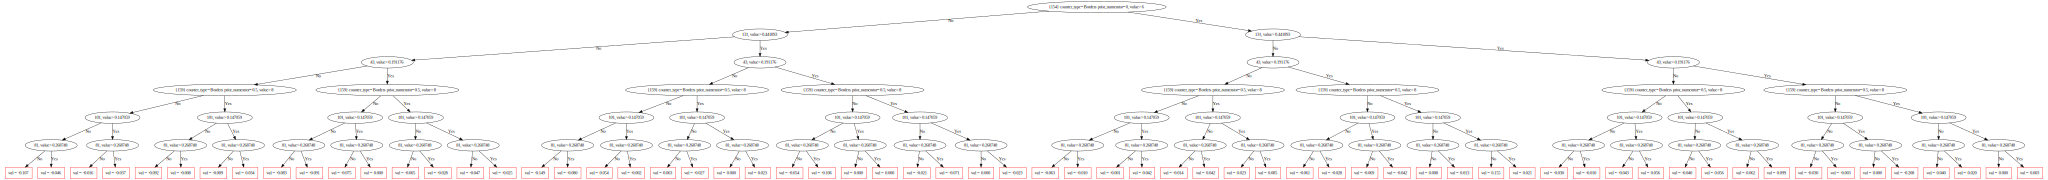

In [45]:
model.plot_tree(1)

In [46]:
def custom_round(x, base=5):
    return base * round(float(x)/base)


y_pred = pd.Series(y_pred, name='y_pred', index=y_test.index).apply(lambda x: custom_round(x, base=.5))

# Check visualisation of test and pred set to understand the predictions accuracy.
pred_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
dtale.show(pred_df)

In [47]:
# Save file for submission
test_catboost['rating_num'] = model.predict(test_catboost[features])
test_catboost['rating_num'] = test_catboost['rating_num'].apply(lambda x: custom_round(x, base=.5))

submission = test_catboost.reset_index()[['row_id', 'rating_num']]

submission.to_csv(f'{DATA_DIR}/v{version}_cbr_{eval_metric}_{max_depth}_{early_stopping_rounds}_{learning_rate}-{rmse}_{mae}_{r2}.csv', index=False)

In [30]:
# best = pd.read_csv(f"{DATA_DIR}/v0.1_cbr_R2_6_0.1-1_1_0.34-final.csv")
# best

,row_id,rating_num
0,14785,6.5
1,15125,5.0
2,13095,6.5
3,6079,6.0
4,16584,5.5
...,...,...
8769,21259,5.0
8770,9371,9.0
8771,23226,6.0
8772,26623,6.5


In [31]:
# submission

,row_id,rating_num
0,14785,6.5
1,15125,6.0
2,13095,6.5
3,6079,7.0
4,16584,6.5
...,...,...
8769,21259,5.5
8770,9371,8.5
8771,23226,6.5
8772,26623,7.0
